# PPO for Quantum system control
In this simulation we are going to test the PPO algorithm in a simulation of a quantum environment, It is data-based model for two-level system
Majority of this code is from: https://github.com/ManuelGuatto/RL_4_Robust_QC/blob/main/DBL_Damping.ipynb

## Import dependencies

In [1]:
import gym, scipy.linalg, tensorboard
import qiskit
import qiskit.quantum_info as qi
from qiskit.quantum_info.states import DensityMatrix
from qiskit.quantum_info import state_fidelity
import math
import numpy as np
from gym.spaces.box import Box
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import pandas as pd
import os
import optuna
import plotly.express as px

## Define the enviroment 

In [2]:
class Quantum_dynamics(gym.Env):

    MAX_STEPS = 500
    FIDELITY_THRESHOLD = 0.95

    def __init__(self, env_config):

        #Define the action and observation spaces
        self.action_space = Box(-1,1,shape=(1,), dtype=np.float64)
        self.observation_space = Box(low=-1, high=1, shape=(2, 2), dtype=np.float64)

        #Define the epsilon variable for the measurement 
        self.eps = env_config["eps"]
        ##Define the probability of the noise
        self.gamma = env_config["alpha"]
        gamma_2 = 0
        gamma_1 = self.gamma/2
        gamma_3 = self.gamma/2
        #Define the target state
        self.rho_target = env_config["target"]

        #Define the measurement operators
        self.meas_operators = {
                                "M0": np.matrix([[np.sqrt(1-(self.eps)), 0], [0, np.sqrt(self.eps)]]),
                                "M1": np.matrix([[np.sqrt(self.eps), 0], [0, np.sqrt(1-(self.eps))], ]),
                                
                              }
        self.meas_outcomes = np.array([0,1,])
        
        #Define flip channel kraus representation 
        self.K = {"k0": np.matrix([[1,0], [0, np.sqrt(1-gamma_1)]]),
                  "k01": np.matrix([[0,np.sqrt(gamma_1)], [0, 0] ]),
                                                                     }
        
        #Hamiltonian components
        self.a = np.matrix([[0,0], [1,0]])

    def reset(self):
        self.rho = qi.random_density_matrix(2)
        self.rho_hat = self.rho
        self.true_fidelity = 0
        self.fidelity = 0
        self.count = 0
        self.reward = 0
        self.done = False
        self.info = {}

        return self.rho

    def step(self, action):
        #Check the state of the episode
        if self.done:
            # should never reach this point
            print("EPISODE DONE!!!")
        elif (self.count == self.MAX_STEPS):
            self.done = True;
        else:
            assert self.action_space.contains(action)
            self.count += 1

    
        #Noise effect on the state
        #Compute the effect of the noise
        rho = np.matrix(self.rho)
        rho_prime = np.zeros((2,2)).astype(complex)
        for k_i in self.K.values():
            rho_prime += k_i*rho*k_i.getH()
        
        self.rho = rho_prime
        self.rho = DensityMatrix(self.rho) 
        self.rho_hat = DensityMatrix(self.rho_hat)
            
            
        #Define the effect of the unitary operator
        self.beta = action
        a_dagger = np.transpose(np.conjugate(self.a))
        self.control_hamiltonian = (1j)*np.matrix(self.beta[0]*a_dagger - np.conj(self.beta)[0]*self.a)
        self.u = np.matrix(scipy.linalg.expm((-1j)*self.control_hamiltonian))
        op = qi.Operator(self.u)

        # rho prime --> rho after the impulse control
        self.rho = self.rho.evolve(op)
        self.rho_hat = self.rho_hat.evolve(op)

        #Compute the measurement
        outcome = self.measurement()

        #Compute the reward
        fid = self.compute_fidelity()
        self.fidelity = fid[0]
        self.true_fidelity = fid[1]
        if self.done:
            self.reward = self.fidelity
        else:
            self.reward = 0
        
        self.info = {"Fidelity": self.true_fidelity}
        #try:
        #    assert self.observation_space.contains(self.rho)
        #except AssertionError:
        #    print("INVALID STATE", self.rho)
        return [self.rho_hat, self.reward, self.done, self.info]
    
    def measurement(self):

        #Initialize the probabilities
        self.outcomes_probabilities = np.array([1/2,1/2])

        #Compute the probabilities for each m outcome
        for m, M_m in enumerate(self.meas_operators.values()):
            M_m_dagger = np.transpose(np.conjugate(M_m))
            self.outcomes_probabilities[m] = np.trace(np.matmul(np.matmul(M_m_dagger,M_m),np.matrix(self.rho)))
        add_prob = 1-sum(self.outcomes_probabilities)
        self.outcomes_probabilities[1] += add_prob
        
        #Do the measure
        out = np.random.choice(self.meas_outcomes, 1, p=self.outcomes_probabilities)
        key_list=list(self.meas_operators.keys())
        key = key_list[out[0]]
        M_m = self.meas_operators[key]

        #Effect of the measurement on the state
        self.rho = np.matrix((np.matmul(np.matmul(M_m,np.matrix(self.rho)),M_m.getH())))/np.trace(np.matmul(np.matmul(M_m,np.matrix(self.rho)),M_m.getH()))
        self.rho_hat = np.matrix((np.matmul(np.matmul(M_m,np.matrix(self.rho_hat)),M_m.getH())))/np.trace(np.matmul(np.matmul(M_m,np.matrix(self.rho_hat)),M_m.getH()))
        return out

    def compute_fidelity(self):
        rho_hat = DensityMatrix(self.rho_hat)
        rho_true = DensityMatrix(self.rho)
        target = DensityMatrix(self.rho_target)
        fidelity = state_fidelity(rho_hat, target)
        true_fidelity = state_fidelity(rho_true, target)
        
        if fidelity > self.FIDELITY_THRESHOLD:
            self.done = True

        return fidelity, true_fidelity
        

## Import the PPO

In [3]:
from stable_baselines3 import PPO
from datetime import datetime

## Configure the environment

In [4]:
# Select the epsilon for which we have to train a model
eps = np.array([0.1, 0.15, 0.175, 0.2, 0.25, 0.3])
#Target state
rho_target = np.matrix([[0, 0], [0,1]])
#Training noise
alpha_train = np.array([0, 0.1, 0.2, 0.3, 0.4,0.5, 0.6,0.7,0.8,0.9,1])

#Define total training timesteps
training_steps = 70_000

In [5]:
def evaluate_policy(model, env, episodes = 10):
    agent = model
    fidelity = np.zeros(episodes)
    rewards = np.zeros(episodes)
    length = np.zeros(episodes)
    for ep in range(episodes):
        fidelity_ep = 0
        length_ep = 0
        obs = env.reset()
        done = False
        lstm_states = None
        num_envs = 1
        episode_starts = np.ones((num_envs,), dtype=bool)
        while not done:
            length_ep +=1
            action, lstm_states = agent.predict(obs, state = lstm_states, episode_start=episode_starts, deterministic=True)
            obs, reward, done, info = env.step(action)
            episode_starts = done
            if done:
                fidelity_ep = info["Fidelity"]
                fidelity[ep] = fidelity_ep
                length[ep] = length_ep
                rewards[ep] = reward
    fidelity_mean = np.mean(fidelity)
    len_mean = np.mean(length)
    reward_mean = np.mean(rewards)
    return [fidelity_mean, len_mean, reward_mean, fidelity, length, rewards]

## Start train

In [6]:
#We are creating a model for each epsilon that we want to test, the entire training is without noise
evaluate_episodes = 10
df_train = pd.DataFrame(columns = ['epsilon', 'alpha', 'reward', 'timesteps', 'fidelity'])
df_train_mean = pd.DataFrame(columns = ['epsilon', 'alpha', 'reward', 'reward_std', 'timesteps', 'timesteps_std', 'fidelity', 'fidelity_std'])
for epsilon in eps:
    for alpha in alpha_train:
        env_config = {"target": rho_target,
                 "eps": epsilon,
                 "alpha":alpha}
        env = Quantum_dynamics(env_config)
        model = PPO("MlpPolicy", env, learning_rate = 3e-4, verbose = 0,
                             batch_size = 128 , n_steps=640, ent_coef=0.02, tensorboard_log="./Agent2")

        print("##### START TRAINING FOR EPSILON = " + str(epsilon)+ " , ALPHA =  "+ str(alpha) + " #####")
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Starting_time =", current_time)
        model.learn(total_timesteps=training_steps, tb_log_name="Agent_eps"+str(epsilon)+"_alpha_"+str(alpha)+"_filter")

        #Test the agent
        mean_fidelity, mean_length, mean_reward, fidelity_per_episode, length_per_episode,reward_per_episode = evaluate_policy(model, env, episodes = evaluate_episodes)

        std_fidelity = np.std(fidelity_per_episode)
        std_reward = np.std(reward_per_episode)
        std_length = np.std(length_per_episode)


        df_session = pd.concat([pd.DataFrame([[epsilon,
                                               alpha,
                                               reward_per_episode[i],
                                               length_per_episode[i],
                                               fidelity_per_episode[i]]],
                                               columns = ['epsilon', 'alpha', 'reward', 'timesteps', 'fidelity']) 
                                               for i in range(evaluate_episodes)],
                                            ignore_index = True)
        df_train = pd.concat([df_train, df_session], ignore_index = True)

        df_session_mean = pd.concat([pd.DataFrame([[epsilon,
                                                    alpha,
                                                    mean_reward,
                                                    std_reward,
                                                    mean_length,
                                                    std_length,
                                                    mean_fidelity,
                                                    std_fidelity]],
                                                    columns = ['epsilon', 'alpha', 'reward', 'reward_std', 'timesteps', 'timesteps_std', 'fidelity', 'fidelity_std'])],
                                              ignore_index = True)

        df_train_mean = pd.concat([df_train_mean, df_session_mean], ignore_index = True)


        print("## EVALUATE REWARD FOR EPSILON = " + str(epsilon)+": mean reward: " + str(mean_reward) +": std reward: " +
             str(std_reward) + " #####")
        print("## EVALUATE REAL FIDELITY FOR EPSILON = " + str(epsilon) + ": mean fidelity: " + str(mean_fidelity) +": std fidelity: " +
             str(std_fidelity) +" #####")
        print("## EVALUATE LENGTH FOR EPSILON = " + str(epsilon)+": mean length: " + str(mean_length) +": std length: " +
             str(std_length) + " #####")

        # Save a trained model to a file
        print("--> Saving the model")
        model.save("Agent2_eps_"+str(epsilon)+"_alpha_"+str(alpha)+"_filtering")
        print("--> Model saved in  a file")

        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Ending time =", current_time)

        print("##### END TRAINING #####")

C:\Users\Abhimanyu\anaconda3\envs\py310\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


##### START TRAINING FOR EPSILON = 0.1 , ALPHA =  0.0 #####
Starting_time = 00:16:02


C:\Users\Abhimanyu\anaconda3\envs\py310\lib\site-packages\qiskit\quantum_info\states\densitymatrix.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(self.data, dtype=dtype, copy=copy)
C:\Users\Abhimanyu\AppData\Local\Temp\ipykernel_4556\3255825093.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  self.outcomes_probabilities[m] = np.trace(np.matmul(np.matmul(M_m_dagger,M_m),np.matrix(self.rho)))
C:\Users\Abhimanyu\anaconda3\envs\py310\lib\site-packages\stable_baselines3\common\vec_env\dummy_vec_env.py:108: ComplexWarning: Casting complex values to real discards the imaginary part
  self.buf_obs[key][env_idx] = obs
C:\Users\Abhimanyu\anaconda3\envs\py310\lib\site-packages\stable_baselines3\common\preprocessing.py:121: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Copy.c

## EVALUATE REWARD FOR EPSILON = 0.1: mean reward: 0.9792534064797687: std reward: 0.010376727705585863 #####
## EVALUATE REAL FIDELITY FOR EPSILON = 0.1: mean fidelity: 0.9792534064797687: std fidelity: 0.010376727705585863 #####
## EVALUATE LENGTH FOR EPSILON = 0.1: mean length: 2.2: std length: 1.1661903789690602 #####
--> Saving the model
--> Model saved in  a file
Ending time = 00:23:31
##### END TRAINING #####
##### START TRAINING FOR EPSILON = 0.1 , ALPHA =  0.1 #####
Starting_time = 00:23:31
## EVALUATE REWARD FOR EPSILON = 0.1: mean reward: 0.9777508411158223: std reward: 0.014424348836228638 #####
## EVALUATE REAL FIDELITY FOR EPSILON = 0.1: mean fidelity: 0.9777508411158223: std fidelity: 0.014424348836228638 #####
## EVALUATE LENGTH FOR EPSILON = 0.1: mean length: 1.6: std length: 0.66332495807108 #####
--> Saving the model
--> Model saved in  a file
Ending time = 00:30:58
##### END TRAINING #####
##### START TRAINING FOR EPSILON = 0.1 , ALPHA =  0.2 #####
Starting_time = 0

In [7]:
df_train_mean

epsilon  alpha    reward  reward_std  timesteps  timesteps_std  fidelity  \
0       0.1    0.0  0.979253    0.010377        2.2       1.166190  0.979253   
1       0.1    0.1  0.977751    0.014424        1.6       0.663325  0.977751   
2       0.1    0.2  0.974690    0.015141        1.7       1.187434  0.974690   
3       0.1    0.3  0.975215    0.012976        2.2       1.536229  0.975215   
4       0.1    0.4  0.984331    0.009421        2.1       0.830662  0.984331   
..      ...    ...       ...         ...        ...            ...       ...   
61      0.3    0.6  0.969563    0.011487        6.7       3.769615  0.969563   
62      0.3    0.7  0.972632    0.012468        7.3       5.692978  0.972632   
63      0.3    0.8  0.965603    0.007571        9.9       8.336066  0.965603   
64      0.3    0.9  0.970933    0.009597        7.6       4.758151  0.970933   
65      0.3    1.0  0.963670    0.010237        4.9       3.014963  0.963670   

    fidelity_std  
0       0.010377  
1       0.014424  
2       0.015141  
3       0.012976  
4       0.009421  
..           ...  
61      0.011487  
62      0.012468  
63      0.007571  
64      0.009597  
65      0.010237  

[66 rows x 8 columns]

## Test the agent

In [10]:
def test_agent(epsilon_test, alpha_test, target = np.matrix([[0, 0], [0,1]]),  episodes = 100):
    df_test = pd.DataFrame(columns = ['epsilon', 'alpha', 'reward', 'timesteps', 'fidelity'])
    df_test_mean = pd.DataFrame(columns = ['epsilon', 'alpha', 'reward', 'reward_std', 'timesteps', 'timesteps_std', 'fidelity', 'fidelity_std'])
    evaluate_episodes = episodes
    for epsilon in epsilon_test:
        for alpha in alpha_test:
            #Configure the environement for the test
            env_config = {"target": target,
                 "eps": epsilon,
                 "alpha":alpha}
            #Build the environment
            env = Quantum_dynamics(env_config)
            #Load the trained agent
            agent = PPO.load("Agent2_eps_"+str(epsilon)+"_alpha_"+str(alpha)+"_filtering")
            print("##### START TEST FOR AGENT EPSILON: " + str(epsilon)+ " ALPHA: "+ str(alpha) + " #####")
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
            print("Starting_time =", current_time)
            
            #Test the agent
            mean_fidelity, mean_length, mean_reward, fidelity_per_episode, length_per_episode, reward_per_episode = evaluate_policy(agent, env, episodes)

            std_fidelity = np.std(fidelity_per_episode)
            std_reward = np.std(reward_per_episode)
            std_length = np.std(length_per_episode)
            #percentage_solved_episodes = sum(reward > 0.95 for reward in reward_per_episode)
            #percentage_solved_episodes = percentage_solved_episodes/evaluate_episodes
            
            #Create the dataframe
            df_session = pd.concat([pd.DataFrame([[epsilon,
                                                alpha,
                                                reward_per_episode[i],
                                                length_per_episode[i],
                                                fidelity_per_episode[i]]],
                                                columns = ['epsilon', 'alpha', 'reward', 'timesteps', 'fidelity']) 
                                                for i in range(evaluate_episodes)],
                                      ignore_index = True)
            df_test = pd.concat([df_test, df_session], ignore_index = True)
            
            df_session_mean = pd.concat([pd.DataFrame([[epsilon,
                                                    alpha,
                                                    mean_reward,
                                                    std_reward,
                                                    mean_length,
                                                    std_length,
                                                    mean_fidelity,
                                                    std_fidelity]],
                                                    columns = ['epsilon', 'alpha', 'reward', 'reward_std', 'timesteps', 'timesteps_std', 'fidelity', 'fidelity_std'])],
                                          ignore_index = True)
            
            df_test_mean = pd.concat([df_test_mean, df_session_mean], ignore_index = True)

            
            print("## TEST RESULTS:  mean fidelity: " + str(mean_fidelity) +": std fidelity: " +
                 str(std_fidelity) + " #####")
            
            now = datetime.now()
            current_time = now.strftime("%H:%M:%S")
            print("Ending time =", current_time)

            print("##### END TEST #####")
            
    return df_test, df_test_mean

In [11]:
#Define the alpha for the test
alpha_test = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
evaluate_episodes = 100
df_test, df_test_mean = test_agent(epsilon_test = eps, alpha_test = alpha_test)

##### START TEST FOR AGENT EPSILON: 0.1 ALPHA: 0.0 #####
Starting_time = 10:35:53


C:\Users\Abhimanyu\AppData\Local\Temp\ipykernel_4556\3255825093.py:112: ComplexWarning: Casting complex values to real discards the imaginary part
  self.outcomes_probabilities[m] = np.trace(np.matmul(np.matmul(M_m_dagger,M_m),np.matrix(self.rho)))
C:\Users\Abhimanyu\AppData\Local\Temp\ipykernel_4556\1621342422.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test, df_session], ignore_index = True)
C:\Users\Abhimanyu\AppData\Local\Temp\ipykernel_4556\1621342422.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the r

## TEST RESULTS:  mean fidelity: 0.9795549753554497: std fidelity: 0.013469407134753501 #####
Ending time = 10:35:54
##### END TEST #####
##### START TEST FOR AGENT EPSILON: 0.1 ALPHA: 0.1 #####
Starting_time = 10:35:54
## TEST RESULTS:  mean fidelity: 0.9804378176668743: std fidelity: 0.012358589160531286 #####
Ending time = 10:35:55
##### END TEST #####
##### START TEST FOR AGENT EPSILON: 0.1 ALPHA: 0.2 #####
Starting_time = 10:35:55
## TEST RESULTS:  mean fidelity: 0.9769639659254559: std fidelity: 0.01366817840793754 #####
Ending time = 10:35:56
##### END TEST #####
##### START TEST FOR AGENT EPSILON: 0.1 ALPHA: 0.3 #####
Starting_time = 10:35:56
## TEST RESULTS:  mean fidelity: 0.9792414080910835: std fidelity: 0.012649810351498467 #####
Ending time = 10:35:57
##### END TEST #####
##### START TEST FOR AGENT EPSILON: 0.1 ALPHA: 0.4 #####
Starting_time = 10:35:57
## TEST RESULTS:  mean fidelity: 0.9783568413294781: std fidelity: 0.012311265031149815 #####
Ending time = 10:35:58
####

In [12]:
df_test_mean

epsilon  alpha    reward  reward_std  timesteps  timesteps_std  fidelity  \
0       0.1    0.0  0.979555    0.013469       2.04       1.399428  0.979555   
1       0.1    0.1  0.980438    0.012359       2.01       1.577942  0.980438   
2       0.1    0.2  0.976964    0.013668       1.90       1.268858  0.976964   
3       0.1    0.3  0.979241    0.012650       1.77       1.103223  0.979241   
4       0.1    0.4  0.978357    0.012311       1.82       1.098909  0.978357   
..      ...    ...       ...         ...        ...            ...       ...   
61      0.3    0.6  0.970868    0.012191       8.98       5.761909  0.970868   
62      0.3    0.7  0.971179    0.012003       7.46       5.884590  0.971179   
63      0.3    0.8  0.964077    0.008342       6.98       6.003299  0.964077   
64      0.3    0.9  0.969790    0.012531       9.47       5.872742  0.969790   
65      0.3    1.0  0.967535    0.009613       7.34       6.332803  0.967535   

    fidelity_std  
0       0.013469  
1       0.012359  
2       0.013668  
3       0.012650  
4       0.012311  
..           ...  
61      0.012191  
62      0.012003  
63      0.008342  
64      0.012531  
65      0.009613  

[66 rows x 8 columns]

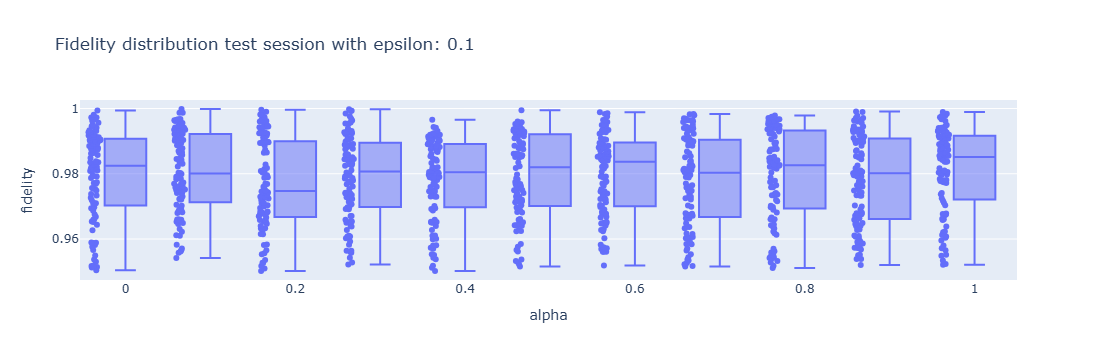

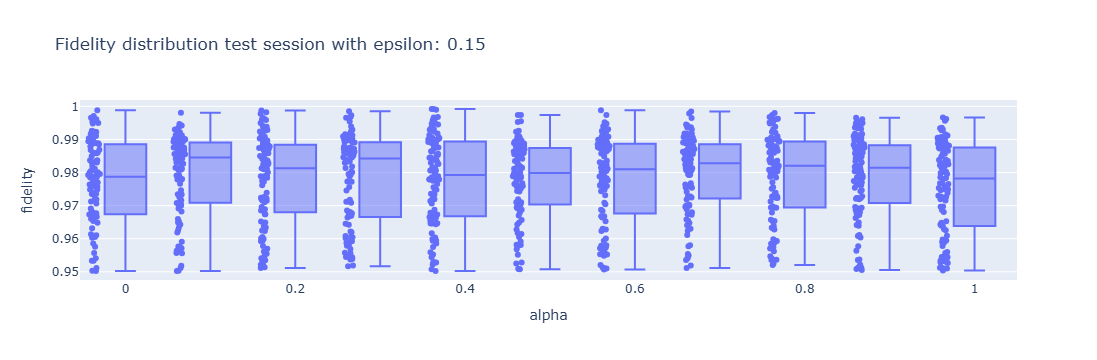

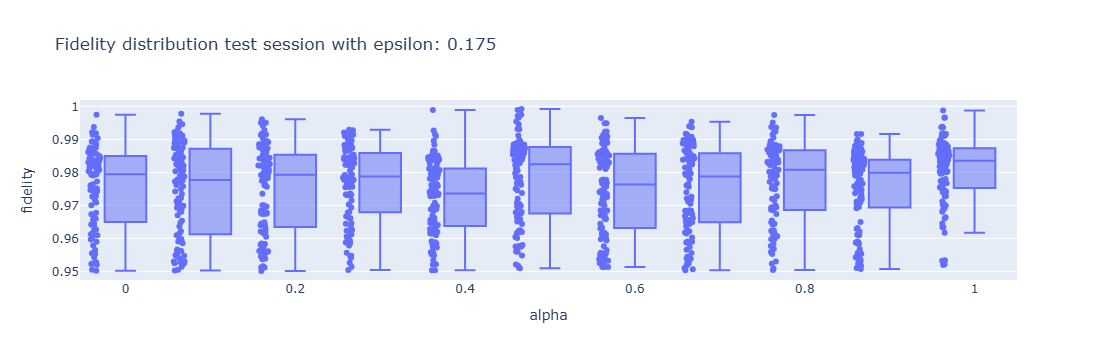

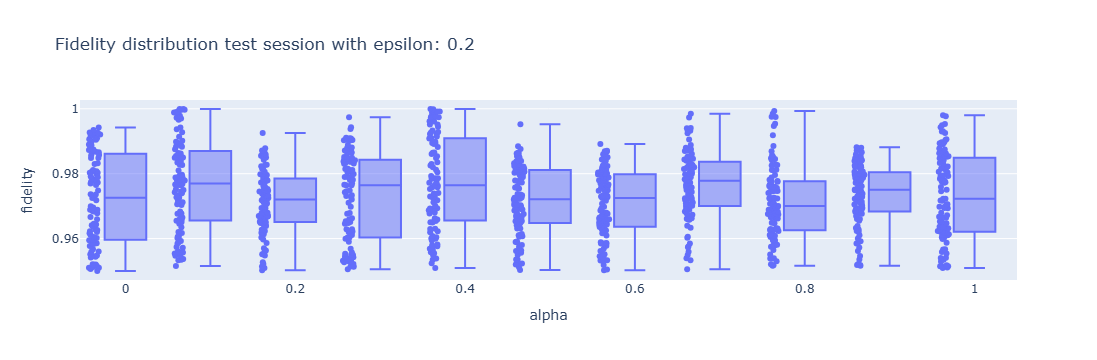

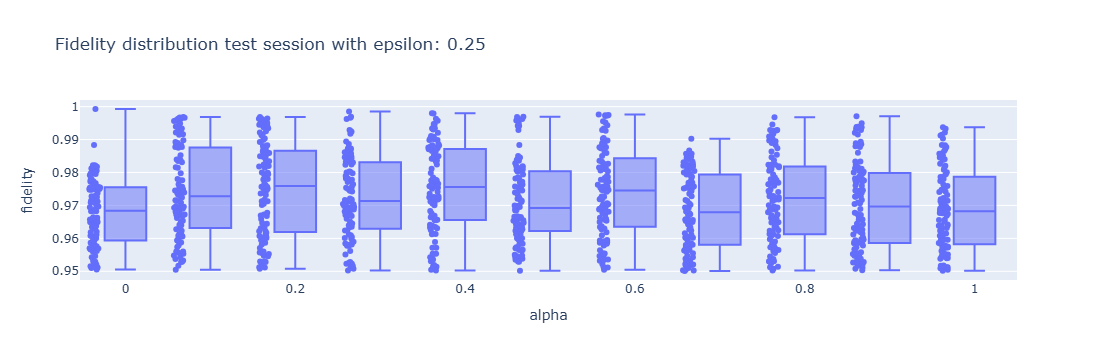

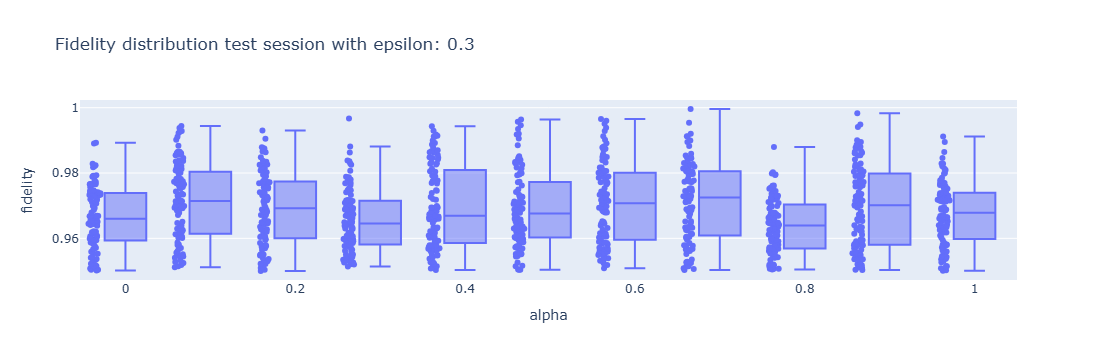

In [13]:
#Visualize the results of the test
for i, epsilon in enumerate(eps):
    i = i+1
    df_eps = df_test[(i-1)*evaluate_episodes*len(alpha_test):(i)*evaluate_episodes*len(alpha_test)]
    fig = px.box(df_eps, x="alpha", y="fidelity", points="all", title="Fidelity distribution test session with epsilon: "+
                str(epsilon))
    fig.show()

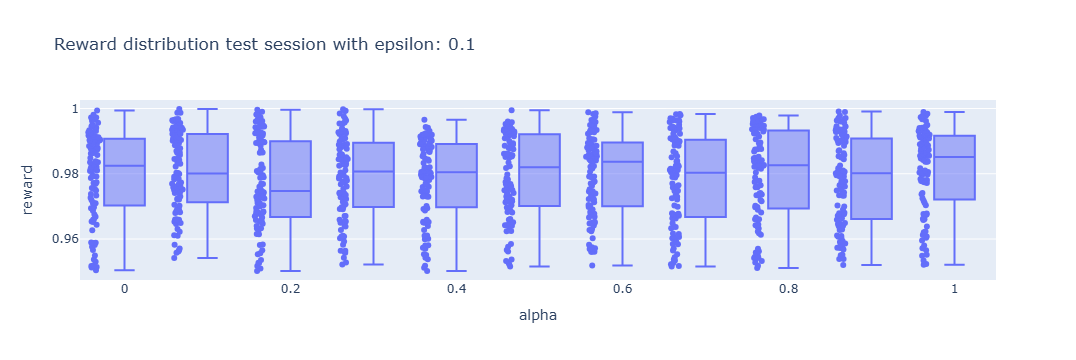

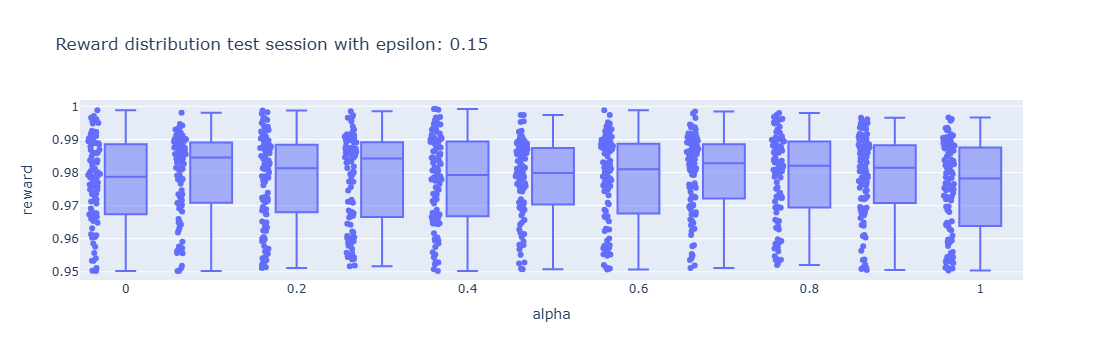

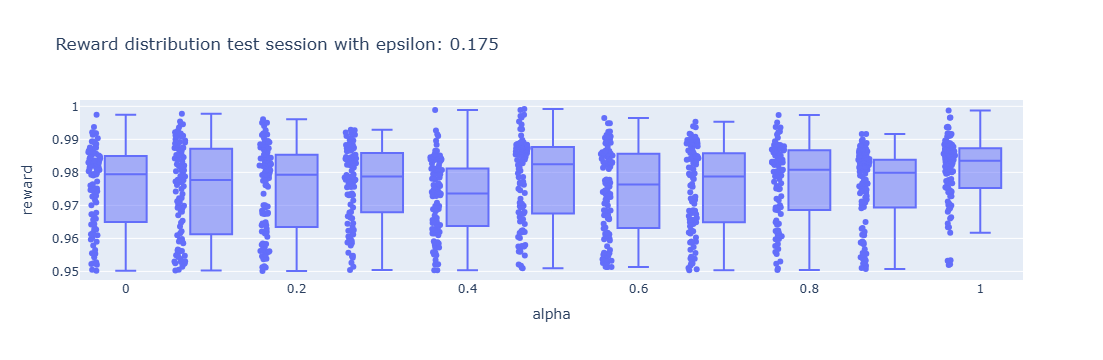

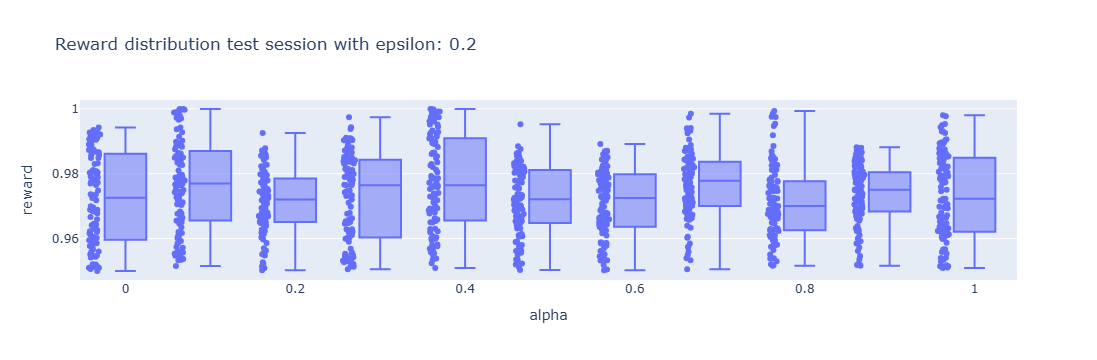

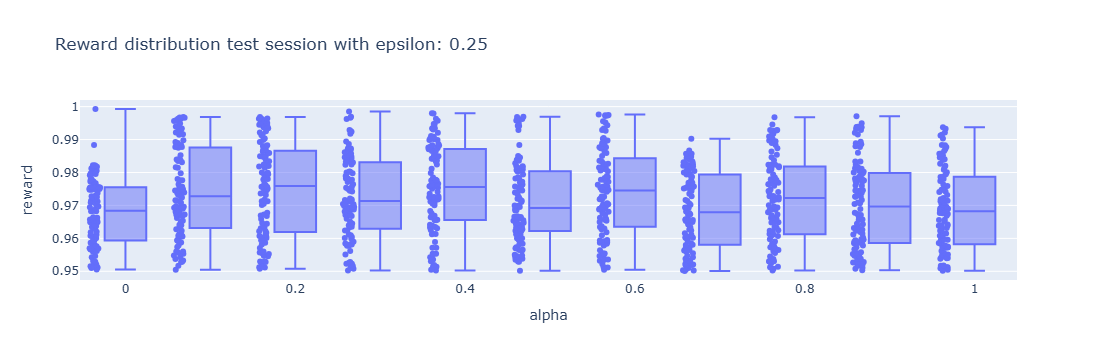

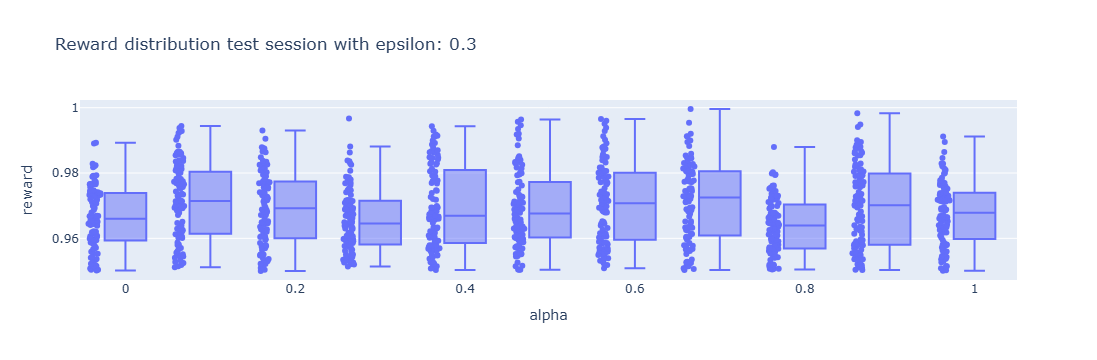

In [14]:
#Visualize the results of the test
for i, epsilon in enumerate(eps):
    i = i+1
    df_eps = df_test[(i-1)*evaluate_episodes*len(alpha_test):(i)*evaluate_episodes*len(alpha_test)]
    fig = px.box(df_eps, x="alpha", y="reward", points="all", title="Reward distribution test session with epsilon: "+
                str(epsilon))
    fig.show()

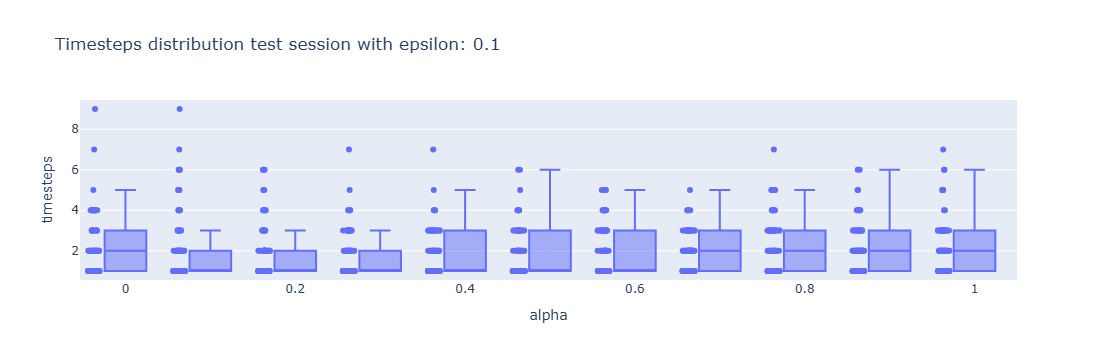

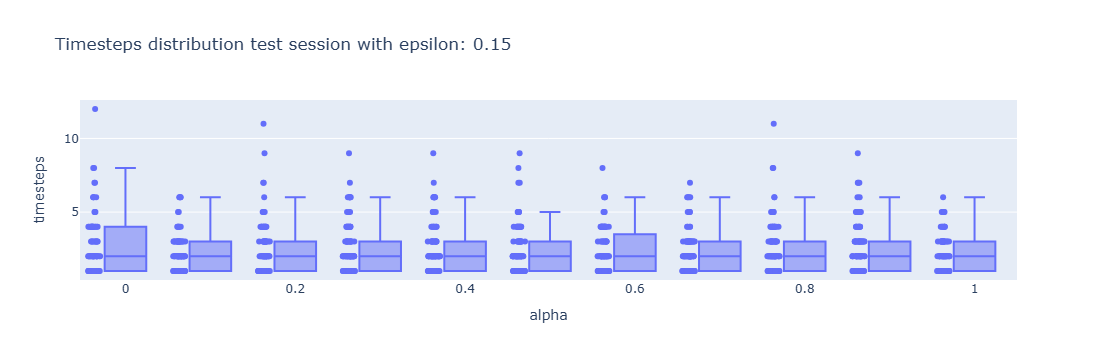

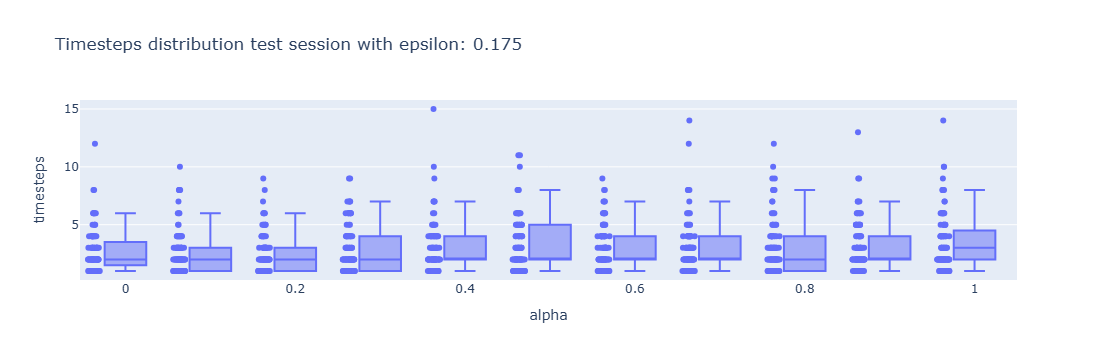

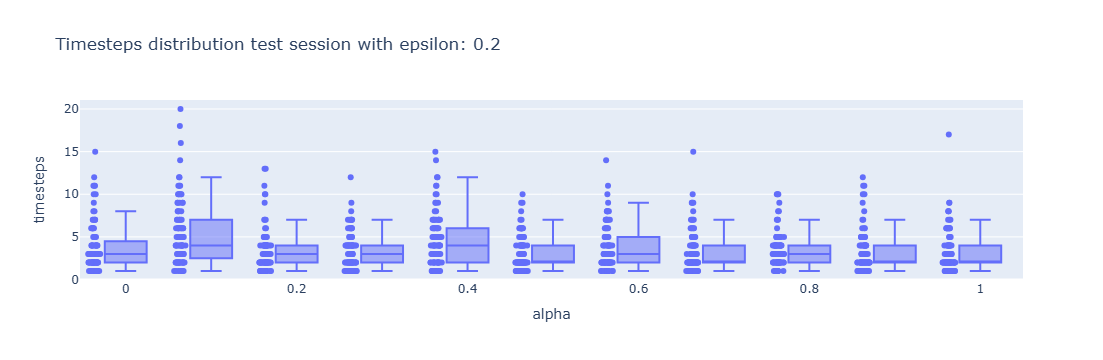

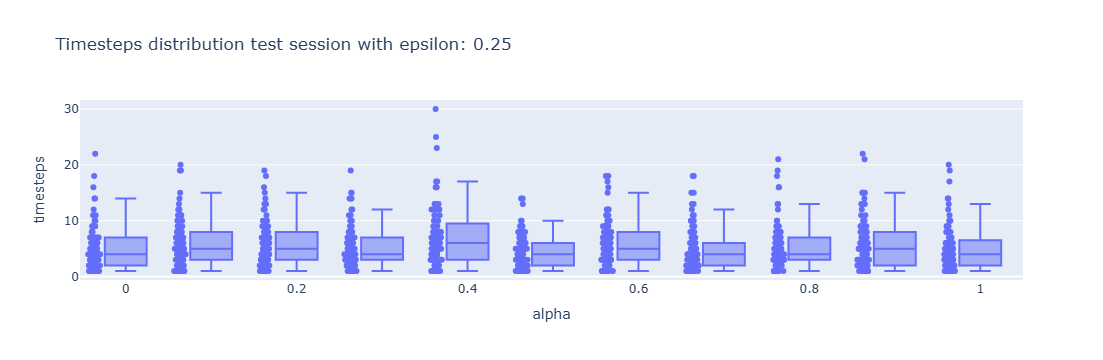

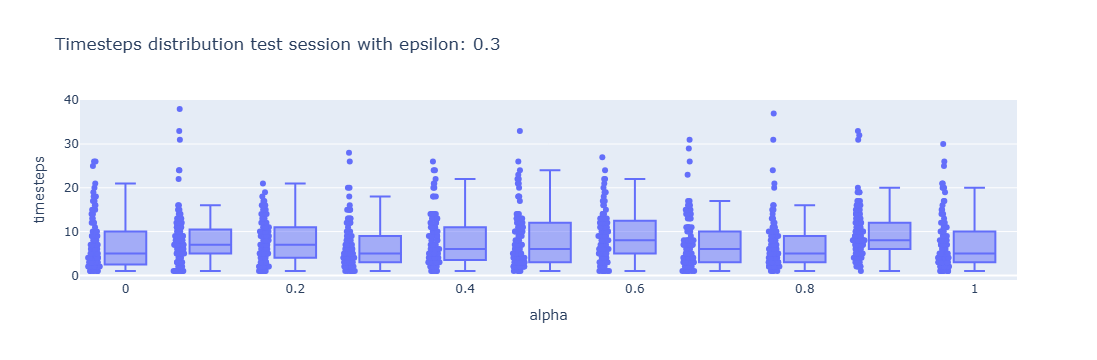

In [15]:
#Visualize the results of the test
for i, epsilon in enumerate(eps):
    i = i+1
    df_eps = df_test[(i-1)*evaluate_episodes*len(alpha_test):(i)*evaluate_episodes*len(alpha_test)]
    fig = px.box(df_eps, x="alpha", y="timesteps", points="all", title="Timesteps distribution test session with epsilon: "+
                str(epsilon))
    fig.update_traces(orientation='v')
    fig.show()

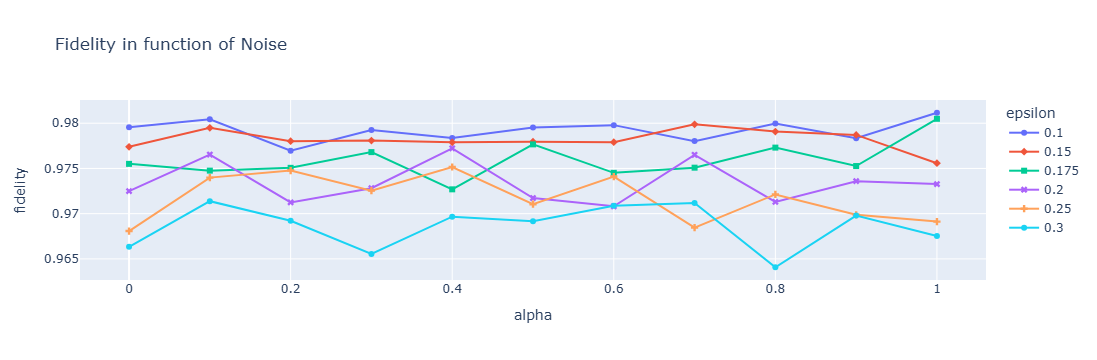

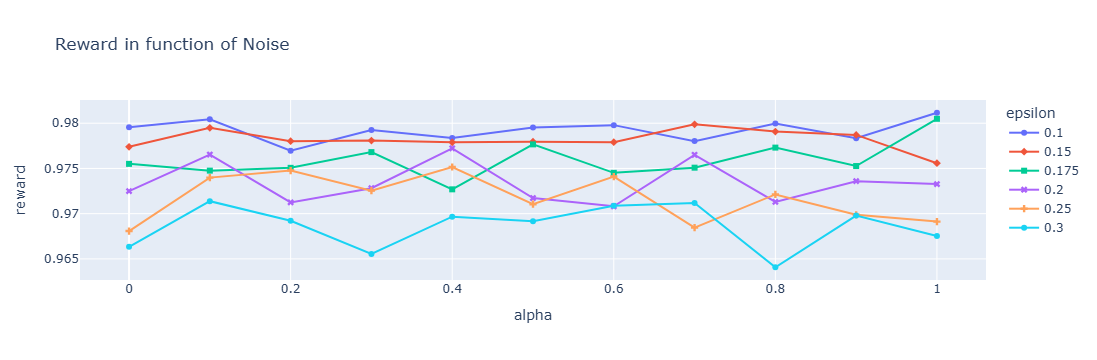

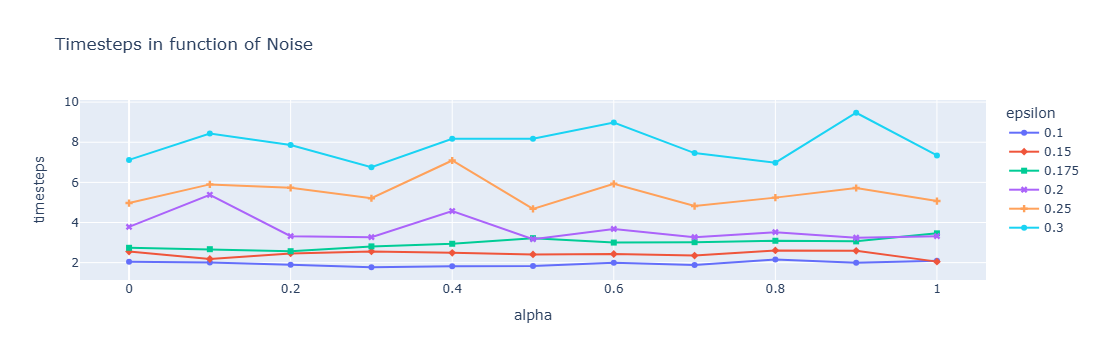

In [16]:
fig = px.line(df_test_mean, x='alpha', y='fidelity', color='epsilon', symbol="epsilon",
             title = 'Fidelity in function of Noise')
fig.show()

fig = px.line(df_test_mean, x='alpha', y='reward', color='epsilon', symbol="epsilon",
             title = 'Reward in function of Noise')
fig.show()

fig = px.line(df_test_mean, x='alpha', y='timesteps', color='epsilon', symbol="epsilon",
             title = 'Timesteps in function of Noise')
fig.show()

In [17]:
heatmap_table = pd.pivot_table(df_test_mean, values='fidelity', index=['epsilon'],
                    columns=['alpha'])

sns.set(rc={"figure.figsize":(12, 6)}) #width=8, height=4

<AxesSubplot:xlabel='alpha', ylabel='epsilon'>

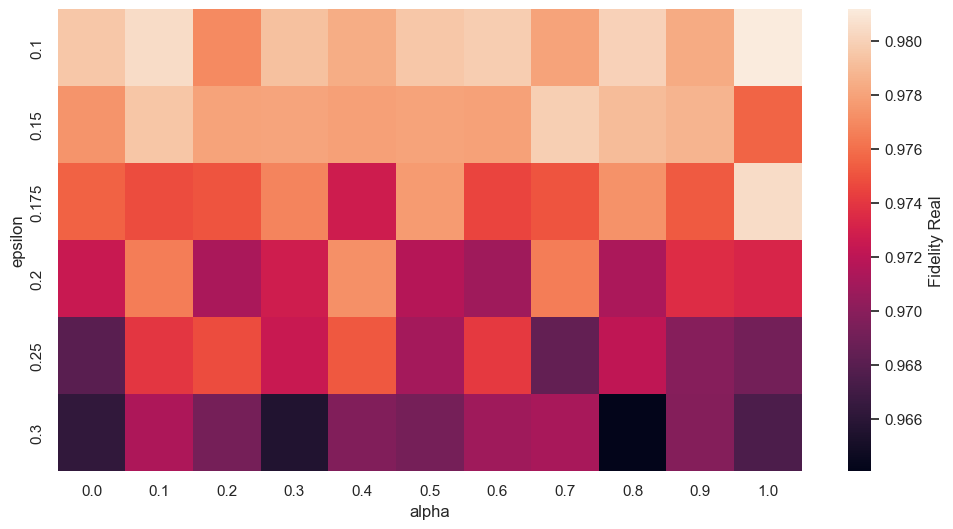

In [18]:
sns.heatmap(heatmap_table, cbar_kws={'label': 'Fidelity Real'})

In [19]:
heatmap_table = pd.pivot_table(df_test_mean, values='reward', index=['epsilon'],
                    columns=['alpha'])

sns.set(rc={"figure.figsize":(12, 6)}) #width=8, height=4

<AxesSubplot:xlabel='alpha', ylabel='epsilon'>

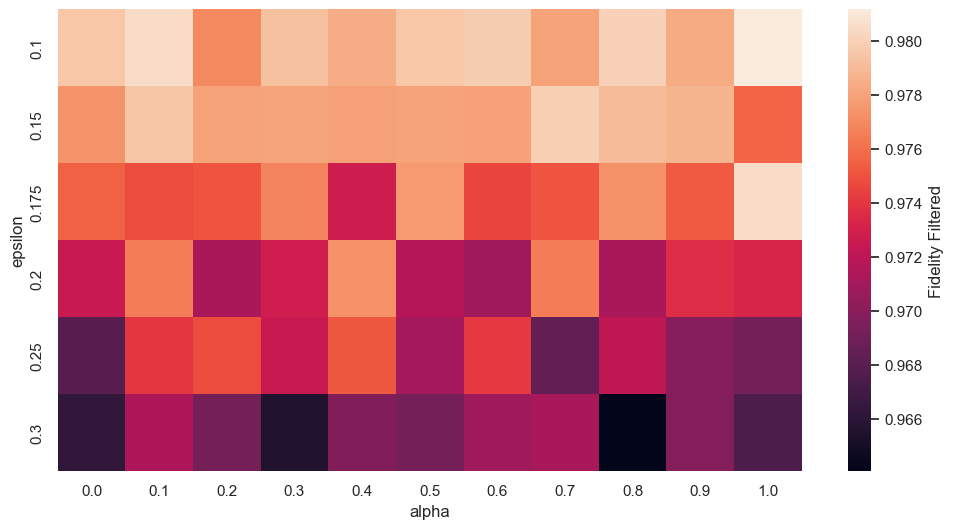

In [20]:
sns.heatmap(heatmap_table, cbar_kws={'label': 'Fidelity Filtered'})

In [21]:
heatmap_table = pd.pivot_table(df_test_mean, values='timesteps', index=['epsilon'],
                    columns=['alpha'])

sns.set(rc={"figure.figsize":(12, 6)}) #width=8, height=4

In [ ]:
sns.heatmap(heatmap_table, cmap="Blues", cbar_kws={'label': 'Timesteps'})

In [ ]:
os.makedirs('data2/df_test', exist_ok=True)  
os.makedirs('data2/df_test_mean', exist_ok=True)  
df_test.to_csv('data2/df_test/data.csv') 
df_test_mean.to_csv('data2/df_test_mean/data.csv')